# Uitwerkingen H7: 7.49

In [2779]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Polygon, Arc


In [2780]:
puntlasten = np.array([[]])  # [position (m), magnitude (kN)]
koppel = np.array([[]])  # [position (m), magnitude (kNm)]
verdeeldeBelasting = np.array([[]])  # [start position (m), end position (m), magnitude (kN/m)]

lengteBalk = 10.0    # lengte van de balk [m]
A = 0.0         # positie oplegging A (rol) [m]
B = 10.0        # positie oplegging B (scharnier) [m]

#puntlasten = np.array([ [2, 0, -10],[8, 0, -10] ])  # [position (m), magnitude (kN)]
#koppel = np.array([[5, -20]])  # [position (m), magnitude (kNm)]
verdeeldeBelasting = np.array([[0, 10, -5]])  # [start position (m), end position (m), magnitude (kN/m)]

divs = 10000  # aantal deelstukken voor de balk
dx = lengteBalk / divs  # lengte van een deelstuk [m]
X = np.arange(0, lengteBalk + 2*dx, dx)  # x-coordinaten van de deelstukken [m]
nPL = len(puntlasten[0])  # aantal puntlasten
nPM = len(koppel[0])  # aantal puntmomenten
nVB = len(verdeeldeBelasting[0])  # aantal verdeelde lasten

reactieKrachten = np.array([0,0,0])  # [Va (kN), Ha (kN), Vb (kN)]
shearForce = np.empty([0,len(X)])  # schuifkracht langs de balk [kN]
bendingMoment = np.empty([0,len(X)])  # buigend moment langs de balk [k


In [2781]:
def reactie_PL(n):
    xp = puntlasten[n,0]
    fx = puntlasten[n,1]
    fy = puntlasten[n,2]

    la_p = A - xp
    mp = fy * la_p
    la_vb = B - A

    Vb = mp / la_vb
    Va = -fy - Vb
    Ha = -fx

    return Va, Vb, Ha

def reactie_PM(n):
    xm = koppel[n,0]
    m = koppel[n,1]

    la_vb = B - A

    Vb = m / la_vb
    Va = - Vb

    return Va, Vb

def reactie_VB(n):
    xStart = verdeeldeBelasting[n,0]
    xEnd = verdeeldeBelasting[n,1]
    fy = verdeeldeBelasting[n,2]

    fy_Res = fy * (xEnd - xStart)  # resulterende kracht van de UDL
    x_Res = xStart + 0.5 * (xEnd - xStart)  # positie van de resulterende kracht van de UDL    

    la_p = A - x_Res
    mp = fy_Res * la_p
    la_vb = B - A

    Vb = mp / la_vb
    Va = - fy_Res - Vb

    return Va, Vb

In [2782]:
PL_record = np.empty([0,3])  # [Va (kN), Vb (kN), Ha (kN)]
if (nPL > 0):

    for n, p in enumerate(puntlasten):
        va, vb, ha = reactie_PL(n)
        PL_record = np.append(PL_record, [np.array([va, ha, vb])], axis=0)

        reactieKrachten[0] += va
        reactieKrachten[1] += ha
        reactieKrachten[2] += vb

PM_record = np.empty([0,2])  # [Va (kN), Vb (kN), Ha (kN)]
if (nPM > 0):
    for n, p in enumerate(koppel):
        va, vb = reactie_PM(n)
        PM_record = np.append(PM_record, [np.array([va, vb])], axis=0)

        reactieKrachten[0] += va
        #reactieKrachten[1] += ha
        reactieKrachten[2] += vb

VB_record = np.empty([0,2])  # [Va (kN), Vb (kN), Ha (kN)]
if (nVB > 0):
    for n, p in enumerate(verdeeldeBelasting):
        va, vb = reactie_VB(n)
        VB_record = np.append(VB_record, [np.array([va, vb])], axis=0)

        reactieKrachten[0] += va
        #reactieKrachten[1] += ha
        reactieKrachten[2] += vb

In [2783]:
def shear_moment_PL(n):
    xp = puntlasten[n,0]
    #fx = puntlasten[n,1]
    fy = puntlasten[n,2]
    Va = PL_record[n,0]
    Vb = PL_record[n,2]

    Shear = np.zeros(len(X))
    Moment = np.zeros(len(X))

    for i, x in enumerate(X):
        shear = 0
        moment = 0

        if x > A:
            shear = shear + Va
            moment = moment + Va * (x - A)

        if x > xp:
            shear = shear + fy
            moment = moment + fy * (x - xp)

        if x > B:
            shear = shear + Vb
            moment = moment + Vb * (x - B)

        Shear[i] = shear
        Moment[i] = moment

    return Shear, Moment

def shear_moment_PM(n):
    xm = koppel[n,0]
    m = koppel[n,1]
    Va = PM_record[n,0]
    Vb = PM_record[n,1]

    Shear = np.zeros(len(X))
    Moment = np.zeros(len(X))

    for i, x in enumerate(X):
        shear = 0
        moment = 0

        if x > A:
            shear = shear + Va
            moment = moment + Va * (x - A)

        if x > xm:
            moment = moment + m

        if x > B:
            shear = shear + Vb
            moment = moment + Vb * (x - B)

        Shear[i] = shear
        Moment[i] = moment

    return Shear, Moment

def shear_moment_UDL(n):
    xStart = verdeeldeBelasting[n,0]
    xEnd = verdeeldeBelasting[n,1]
    fy = verdeeldeBelasting[n,2]
    Va = VB_record[n,0]
    Vb = VB_record[n,1]

    Shear = np.zeros(len(X))
    Moment = np.zeros(len(X))

    for i, x in enumerate(X):
        shear = 0
        moment = 0

        if x > A:
            shear = shear + Va
            moment = moment + Va * (x - A)

        if x > B:
            shear = shear + Vb
            moment = moment + Vb * (x - B)
        
        if x > xStart and x <= xEnd :
            shear = shear + fy * (x - xStart)
            moment = moment + fy * (x - xStart) * 0.5 * (x - xStart)
        elif( x > xEnd ):
            shear = shear + fy * (xEnd - xStart)
            moment = moment + fy * (xEnd - xStart) * (x-xStart - 0.5 * (xEnd - xStart))



        Shear[i] = shear
        Moment[i] = moment

    return Shear, Moment

In [2784]:
if (nPL > 0):
    for n, p in enumerate(puntlasten):
        Shear, Moment = shear_moment_PL(n)
        shearForce = np.append(shearForce, [Shear], axis=0)
        bendingMoment = np.append(bendingMoment, [Moment], axis=0)

if (nPM > 0):
    for n, p in enumerate(koppel):
        Shear, Moment = shear_moment_PM(n)
        shearForce = np.append(shearForce, [Shear], axis=0)
        bendingMoment = np.append(bendingMoment, [Moment], axis=0)

if (nVB > 0):
    for n, p in enumerate(verdeeldeBelasting):
        Shear, Moment = shear_moment_UDL(n)
        shearForce = np.append(shearForce, [Shear], axis=0)
        bendingMoment = np.append(bendingMoment, [Moment], axis=0)

In [2785]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Polygon, Arc

# --- algemene styling ---
ticks = np.arange(0, lengteBalk + 1, 1)

blok_y0 = 0.05
blok_hoogte = 1
pijl_start_y = blok_y0 + blok_hoogte
pijl_dy = -1.
aantal_pijlen = 9

tri_half = 0.125
tri_base_y = -0.20
tri_apex_y = -0.01
rol_line_y = tri_base_y - 0.05
rol_line_halfwidth = 0.16


def teken_opleggingen(ax):
    """Rol in A, scharnier in B."""
    # Roloplegging bij A
    rol_tri = Polygon(
        [[A - tri_half, tri_base_y],
         [A + tri_half, tri_base_y],
         [A,           tri_apex_y]],
        closed=True, facecolor="gray", edgecolor="black"
    )
    ax.add_patch(rol_tri)
    ax.plot(
        [A - rol_line_halfwidth, A + rol_line_halfwidth],
        [rol_line_y, rol_line_y],
        color="black", linewidth=2
    )

    # Scharnieroplegging bij B
    sch_tri = Polygon(
        [[B - tri_half, tri_base_y],
         [B + tri_half, tri_base_y],
         [B,           tri_apex_y]],
        closed=True, facecolor="gray", edgecolor="black"
    )
    ax.add_patch(sch_tri)


def teken_balk(ax):
    ax.plot([0, lengteBalk], [0, 0], color="black", linewidth=4)


def teken_verdeelde_belasting(ax):
    """Gebruik `verdeeldeBelasting`: [xStart, xEnd, q] (kN/m)."""
    if nVB > 0:
        for vb in verdeeldeBelasting:
            if vb.size == 0:
                continue
            xStart, xEnd, q = vb
            if xEnd <= xStart:
                continue

            belasting = Rectangle(
                (xStart, blok_y0),
                xEnd - xStart,
                blok_hoogte,
                facecolor="green",
                alpha=0.35
            )
            ax.add_patch(belasting)

            sign = -1 if q < 0 else 1
            for xi in np.linspace(xStart, xEnd, aantal_pijlen):
                ax.arrow(
                    xi,
                    pijl_start_y if sign < 0 else pijl_start_y + pijl_dy,
                    0,
                    sign * abs(pijl_dy),
                    head_width=0.1,
                    head_length=0.05,
                    color="green",
                    length_includes_head=True
                )

            ax.text(
                (xStart + xEnd) / 2,
                blok_y0 + blok_hoogte + 0.08,
                f"q = {q:.1f} kN/m",
                ha="center",
                color="green"
            )


def teken_puntlasten(ax):
    """Gebruik `puntlasten`: [x, Fx, Fy] (kN). Alleen Fy getekend."""
    if nPL > 0:
        for pl in puntlasten:
            if pl.size == 0:
                continue
            xp, fx, fy = pl
            if abs(fy) < 1e-9:
                continue

            sign = -1 if fy < 0 else 1
            y_start = 0.30 if sign < 0 else -0.30
            dy = -0.30 if sign < 0 else 0.30

            ax.arrow(
                xp, y_start,
                0, dy,
                head_width=0.08,
                head_length=0.05,
                color="blue",
                length_includes_head=True
            )
            ax.text(
                xp,
                y_start + (dy * 1.1),
                f"{fy:.1f} kN",
                ha="center",
                color="blue"
            )


def teken_koppels(ax):
    """Gebruik `koppel`: [x, M] (kNm)."""
    if nPM > 0:
        for km in koppel:
            if km.size == 0:
                continue
            xC, M_C = km
            if abs(M_C) < 1e-9:
                continue

            radius = 0.35
            arc = Arc(
                (xC, 0.0),
                radius, radius,
                theta1=40, theta2=320,
                edgecolor="purple",
                linewidth=2
            )
            ax.add_patch(arc)

            sign = 1 if M_C >= 0 else -1
            ax.arrow(
                xC + sign * radius / 2,
                0.0,
                -sign * 0.01,
                0.10,
                head_width=0.06,
                head_length=0.04,
                color="purple",
                length_includes_head=True
            )

            ax.text(
                xC,
                -0.18,
                f"M = {M_C:.1f} kNm",
                ha="center",
                color="purple"
            )


def teken_reactiekrachten(ax):
    """Gebruik `reactieKrachten = [Va, Ha, Vb]`."""
    Va, Ha, Vb = reactieKrachten

    for xpos, R in [(A, Va), (B, Vb)]:
        if abs(R) < 1e-9:
            continue

        sign = 1 if R >= 0 else -1
        y_start = -0.28 if sign > 0 else 0.28
        dy = 0.28 * sign

        ax.arrow(
            xpos, y_start,
            0, dy,
            head_width=0.1,
            head_length=0.04,
            color="red",
            length_includes_head=True
        )
        ax.text(
            xpos,
            y_start - 0.2 if sign > 0 else y_start + 0.2,
            f"{R:.1f} kN",
            ha="center",
            color="red"
        )


In [2786]:
print ("De verticale reactiekrachten in A is {one} kN".format(one= round(reactieKrachten[0],2) ))
print ("De verticale reactiekrachten in B is {one} kN".format(one= round(reactieKrachten[2],2) ))

De verticale reactiekrachten in A is 25 kN
De verticale reactiekrachten in B is 25 kN


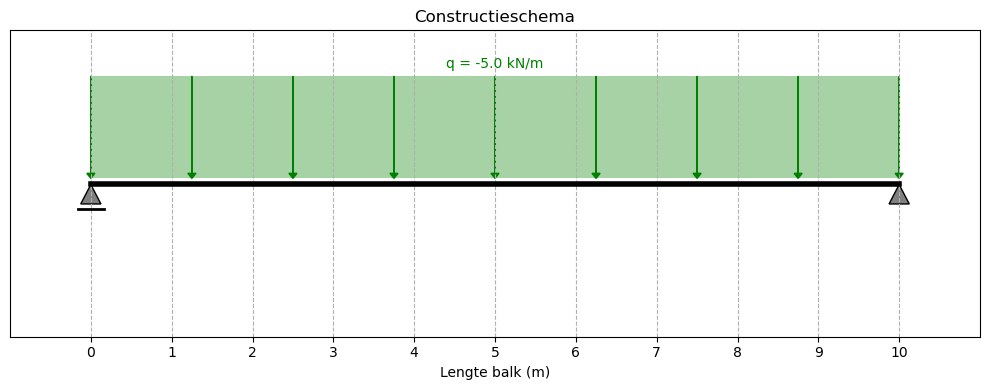

In [2787]:
plt.figure(figsize=(10, 4))

ax = plt.gca()

teken_balk(ax)
teken_opleggingen(ax)
teken_verdeelde_belasting(ax)
teken_puntlasten(ax)
teken_koppels(ax)

ax.set_title("Constructieschema")
ax.set_xlim(-1, lengteBalk + 1)
ax.set_ylim(-1.5, 1.5)
ax.set_yticks([])

ax.set_xticks(ticks)
ax.set_xlabel("Lengte balk (m)")

# zelfde grid-stijl als je andere diagrammen
ax.grid(True, linestyle="--")

plt.tight_layout()
plt.show()


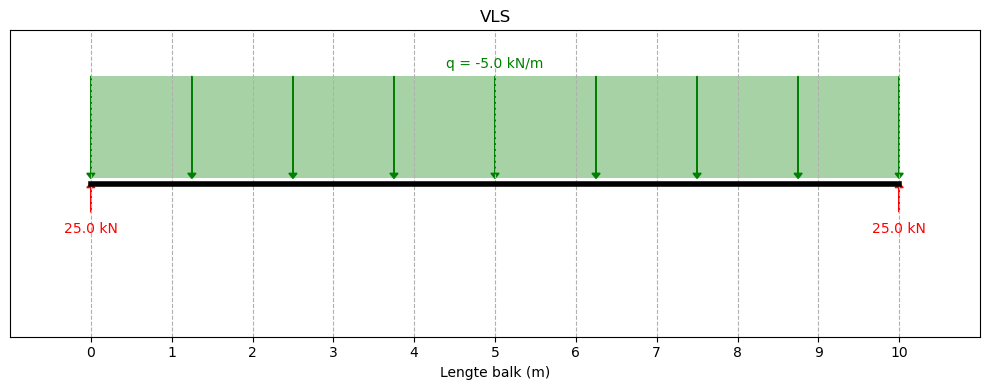

In [2788]:
plt.figure(figsize=(10, 4))

ax = plt.gca()

teken_balk(ax)
#teken_opleggingen(ax)
teken_verdeelde_belasting(ax)
teken_puntlasten(ax)
teken_koppels(ax)
teken_reactiekrachten(ax)

ax.set_title("VLS")
ax.set_xlim(-1, lengteBalk + 1)
ax.set_ylim(-1.5, 1.5)
ax.set_yticks([])

ax.set_xticks(ticks)
ax.set_xlabel("Lengte balk (m)")

ax.grid(True, linestyle="--")

plt.tight_layout()
plt.show()


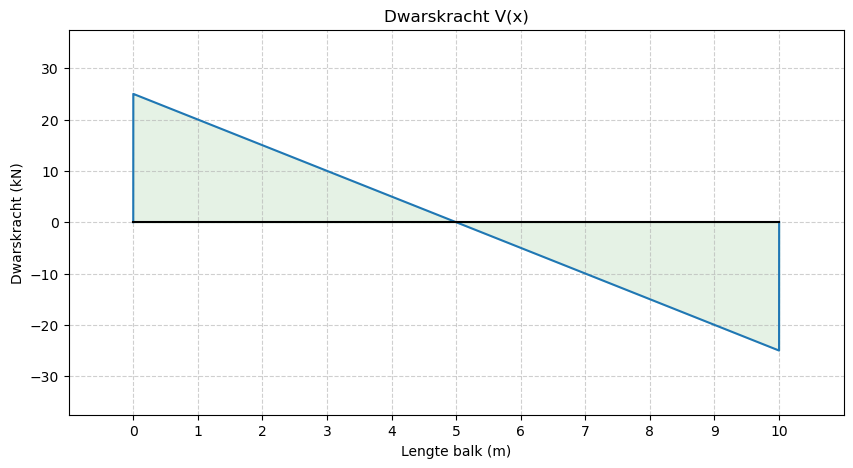

In [2789]:
import matplotlib.pyplot as plt
import numpy as np

# Maak een nieuwe figuur
plt.figure(figsize=(10, 5))

# Dwarsekrachtlijn tekenen
plt.plot(X, np.sum(shearForce, axis=0), label="Dwarskracht (kN)")

# Opvullen onder de lijn
plt.fill_between(X, np.sum(shearForce, axis=0), color='green', alpha=0.1)

# Horizontale as alleen van x = 0 tot x = lengteBalk
plt.plot([0, lengteBalk], [0, 0], color='black')


# Titels en labels
plt.title("Dwarskracht V(x)")
plt.xlabel("Lengte balk (m)")
plt.ylabel("Dwarskracht (kN)")

# x-as bereik zoals in Plotly
plt.xlim(-1, lengteBalk + 1)

# x-as bereik zoals in Plotly
plt.ylim(1.5*min(np.sum(shearForce, axis=0)), 1.5*max(np.sum(shearForce, axis=0)) )

# x-ticks op elke meter
plt.xticks(np.arange(0, lengteBalk + 1, 1))

# **Grid met stippellijnen**
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()


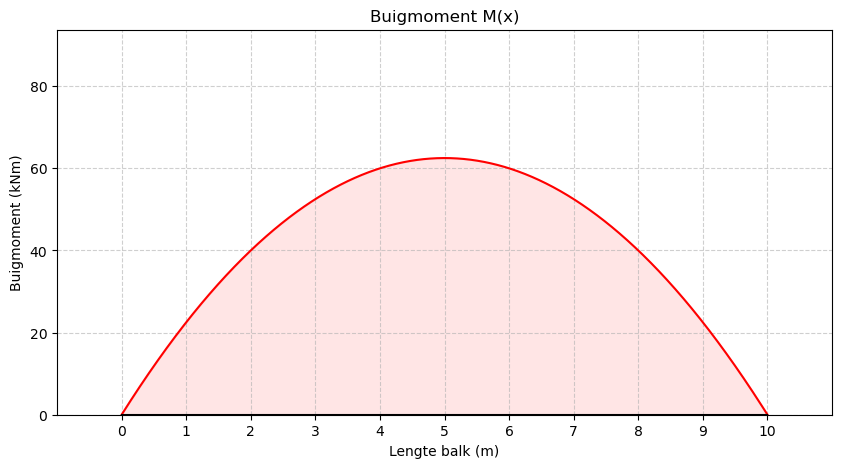

In [2790]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 5))

# Buigmomentlijn
plt.plot(X, np.sum(bendingMoment, axis=0), label="Buigmoment (kNm)", color='red')

# Opvullen onder de lijn
plt.fill_between(X, np.sum(bendingMoment, axis=0), color='red', alpha=0.1)

# Horizontale as alleen van 0 tot lengteBalk
plt.plot([0, lengteBalk], [0, 0], color='black')

# Titels en labels
plt.title("Buigmoment M(x)")
plt.xlabel("Lengte balk (m)")
plt.ylabel("Buigmoment (kNm)")

# Zelfde x-as bereik als Plotly
plt.xlim(-1, lengteBalk + 1)

plt.ylim(1.5*min(np.sum(bendingMoment, axis=0)), 1.5*max(np.sum(bendingMoment, axis=0)) )

# x-ticks op elke meter
plt.xticks(np.arange(0, lengteBalk + 1, 1))

# Grid met stippellijnen (consistent met vorige plot)
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()
